In [102]:
import os
import sys

sys.path.insert(0, '../utils')

import glob
import xgboost as xgb
import tensorflow as tf
from preprocess import process_df, series_to_supervised, oof_idx, scale_data
import pickle
import pandas as pd
import numpy as np


def push(x, y):
    push_len = len(y)
    assert len(x) >= push_len
    x[:-push_len] = x[push_len:]
    x[-push_len:] = y
    return x


def infer_only_meta(df, future_pred=100):
    meta_df = process_df(df, additional_features=True)
    del meta_df['total_cases_nextday']
    meta_data, meta_scaler = scale_data(meta_df.values)
    meta_windowed = series_to_supervised(meta_data, n_in=window_size)
    meta_windowed = np.asarray(meta_windowed).reshape(-1, num_cols_meta, window_size+1)

    final_output = []
    for i in range(future_pred):
        meta_window = meta_windowed[-1, :, :]
        meta_pred = []
        for model in tf_meta_models:
            meta_pred.append(model.predict(np.asarray([meta_windowed[i, :, :-1]]))[0])
        meta_pred = np.array(meta_pred)
        meta_pred = np.mean(meta_pred, axis=0)
        final_output.append(nometa_scaler.inverse_transform(meta_pred[-1])[-1])

        meta_window = np.append(meta_window, np.expand_dims(np.array(meta_pred), axis=1), axis=1)[1:]
    return final_output


def infer_all(df, nometa=True, meta=True, oof=False, future_pred=100, save_name='predictions.csv'):
    if nometa:
        nometa_df = process_df(df.copy())
        del nometa_df['total_cases_nextday'], nometa_df['infected_vaccinated'], nometa_df['total_vaccinated'], nometa_df['infected_unvaccinated']
        # nometa_df = nometa_df.drop('total_cases_nextday', 1)
        nometa_data, nometa_scaler = scale_data(nometa_df.values)
        nometa_windowed = series_to_supervised(nometa_data, n_in=window_size)
    if meta:
        meta_df = process_df(df, additional_features=True)
        del meta_df['total_cases_nextday']
        meta_data, meta_scaler = scale_data(meta_df.values)
        meta_windowed = series_to_supervised(meta_data, n_in=window_size)
        meta_windowed = np.asarray(meta_windowed).reshape(-1, num_cols_meta, window_size+1)
    if oof:
        preds = []
        for i in range(len(meta_windowed[:, :, :-1])):
            nometa_pred = []
            meta_pred = []
            for model in tf_meta_models:
                meta_pred.append(model.predict(np.asarray([meta_windowed[i, :, :-1]]))[0])
            for model in xgb_models:
                nometa_pred.append(model.predict(np.asarray([nometa_windowed[i, :-1]]))[0])
            for model in tf_mlp_models:
                nometa_pred.append(model.predict(np.asarray([nometa_windowed[i, :-1]]))[0])
            for model in tf_sequential_models:
                te = np.expand_dims(nometa_windowed[i, :-1], axis=-1)
                nometa_pred.append(model.predict(np.asarray([te]))[0])
            nometa_pred = np.array(nometa_pred)
            nometa_pred = np.mean(nometa_pred, axis=0)

            meta_pred = np.array(meta_pred)
            meta_pred = np.mean(meta_pred, axis=0)
            meta_windowed[:, :, i] = meta_pred
            nometa_windowed[:, i] = nometa_pred
            preds.append(nometa_scaler.inverse_transform(nometa_pred*0.3+meta_pred[-1]*0.7))
        plt.plot(df['total_cases'].values[window_size:], label='Expected')
        plt.plot(preds, label='Predicted')
        plt.show()
        print(f"{te_idx[0]} mse {mean_squared_error(df['total_cases'].values[window_size:], preds)}")


    final_output = []
    for i in range(future_pred):
        nometa_window = nometa_windowed[-1, :]
        meta_window = meta_windowed[-1, :, :]
        meta_pred = []
        nometa_pred = []
        for model in tf_meta_models:
            meta_pred.append(model.predict(np.asarray([meta_windowed[i, :, :-1]]))[0])
        for model in xgb_models:
            nometa_pred.append(model.predict(np.asarray([nometa_windowed[i, :-1]]))[0])
        for model in tf_mlp_models:
            nometa_pred.append(model.predict(np.asarray([nometa_windowed[i, :-1]]))[0])
        for model in tf_sequential_models:
            te = np.expand_dims(nometa_windowed[i, :-1], axis=-1)
            nometa_pred.append(model.predict(np.asarray([te]))[0])
        nometa_pred = np.array(nometa_pred)
        nometa_pred = np.mean(nometa_pred, axis=0)
        meta_pred = np.array(meta_pred)
        meta_pred = np.mean(meta_pred, axis=0)
        final_output.append(nometa_scaler.inverse_transform(nometa_pred*0.3+meta_pred[-1]*0.7))

        nometa_window = push(nometa_window, [nometa_pred*0.3+meta_pred[-1]*0.7])
        meta_window = np.append(meta_window, np.expand_dims(np.array(meta_pred), axis=1), axis=1)[1:]

    pd.DataFrame({'Predicted_infections': np.array(out)[:, 0]}).to_csv(cave_name, index=False)

    return final_output

In [66]:
window_size = 50
num_cols_meta = 6
num_cols = 1
save_dir = 'models'

xgb_models = []
tf_sequential_models = []
tf_meta_models = []
tf_mlp_models = []

for i in glob.glob(f'../save_dir/*'):
    if 'xgb' in i:
        with open(i, 'rb') as handle:
            trained_model = pickle.load(handle)
            xgb_models.append(trained_model)
    elif 'tf' in i:
        if 'nometa' in i:
            if 'lstm' in i or 'gru' in i or 'cnn' in i:
                tf_sequential_models.append(tf.keras.models.load_model(i))
            elif 'mlp' in i:
                tf_mlp_models.append(tf.keras.models.load_model(i))
        else:
            tf_meta_models.append(tf.keras.models.load_model(i))

In [106]:
out = infer_all(pd.read_csv('../input/observations_2.csv'), save_name='predictions_2.csv')
existing = process_df(pd.read_csv('../input/observations_2.csv'))['total_cases'].values
my = np.append(existing, out)

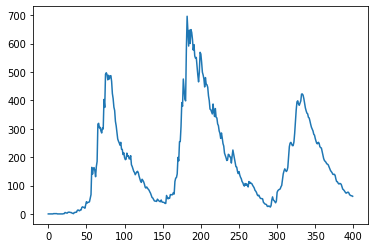

In [109]:
import matplotlib.pyplot as plt
plt.plot(my)
plt.show()